In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14}) #make plots more readable

import palettable as pal

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

In [2]:
##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis


def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
#########################
### Import fits files ###
#########################

#isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#old dr16
olddr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits',1)
clnrold = np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))

clnrolddr16 = olddr16[clnrold]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits', 1)
clnpdfout = pdfout[ np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))]

#Read in Christian's Model
Chrismod = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/abparam16_delgau1.5_1525.txt')

In [4]:
#######################
### Pick out Fields ###
#######################

dor30 = np.where(clndr16['FIELD']=='30Dor')
lmc1 = np.where(clndr16['FIELD']=='LMC1')
lmc2 = np.where(clndr16['FIELD']=='LMC2')
lmc3 = np.where(clndr16['FIELD']=='LMC3')
lmc4 = np.where(clndr16['FIELD']=='LMC4')
lmc5 = np.where(clndr16['FIELD']=='LMC5')
lmc6 = np.where(clndr16['FIELD']=='LMC6')
lmc7 = np.where(clndr16['FIELD']=='LMC7')
lmc8 = np.where(clndr16['FIELD']=='LMC8')
lmc9 = np.where(clndr16['FIELD']=='LMC9')
lmc10 = np.where(clndr16['FIELD']=='LMC10')
lmc11 = np.where(clndr16['FIELD']=='LMC11')
lmc12 = np.where(clndr16['FIELD']=='LMC12')
lmc13 = np.where(clndr16['FIELD']=='LMC13')
lmc14 = np.where(clndr16['FIELD']=='LMC14')
lmc16 = np.where(clndr16['FIELD']=='LMC16')
lmc17 = np.where(clndr16['FIELD']=='LMC17')

In [9]:
def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [10]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
# factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
parage = parsec_age(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])
parage = np.squeeze(parage)

In [11]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [12]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

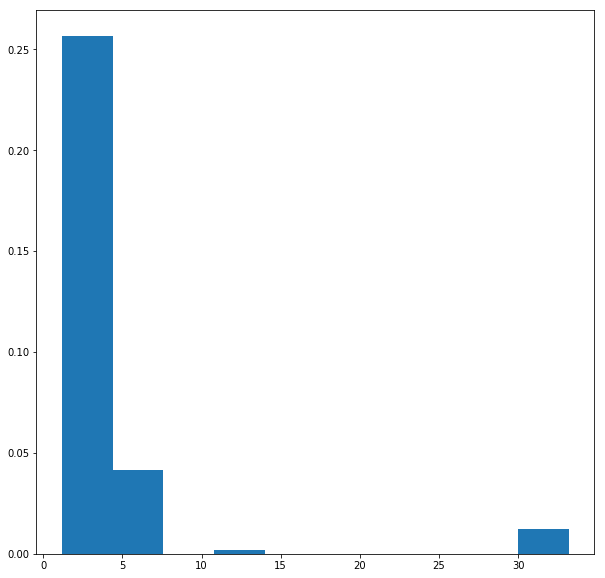

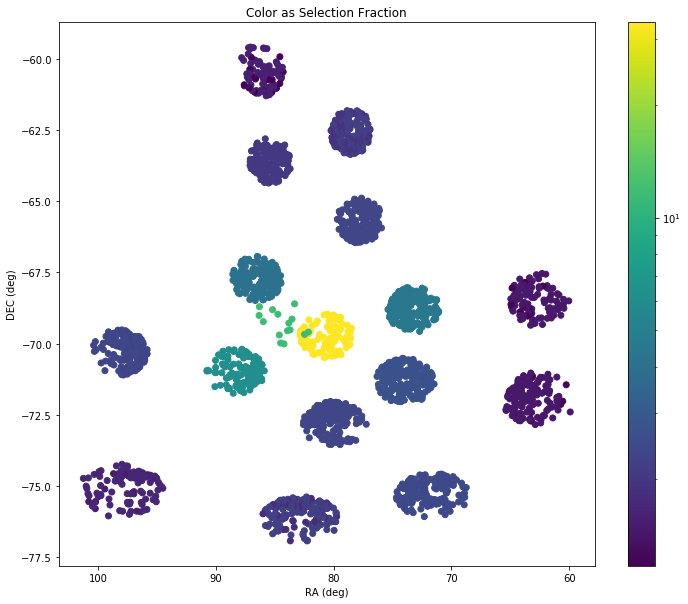

In [13]:
##########################
### Look at SELECTFUNC ###
##########################

'''SELECTFUNC is the ration of RGB to total stars observed'''

#histogram
plt.figure(figsize=[10,10])
plt.hist(clndr16['SELECTFUNC'],density=True)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['RA'],clndr16['DEC'],c=clndr16['SELECTFUNC'],norm=matplotlib.colors.LogNorm())
plt.gca().invert_xaxis()
plt.title(r'Color as Selection Fraction')
plt.colorbar()
plt.xlabel(r'RA (deg)')
plt.ylabel(r'DEC (deg)')
plt.show()

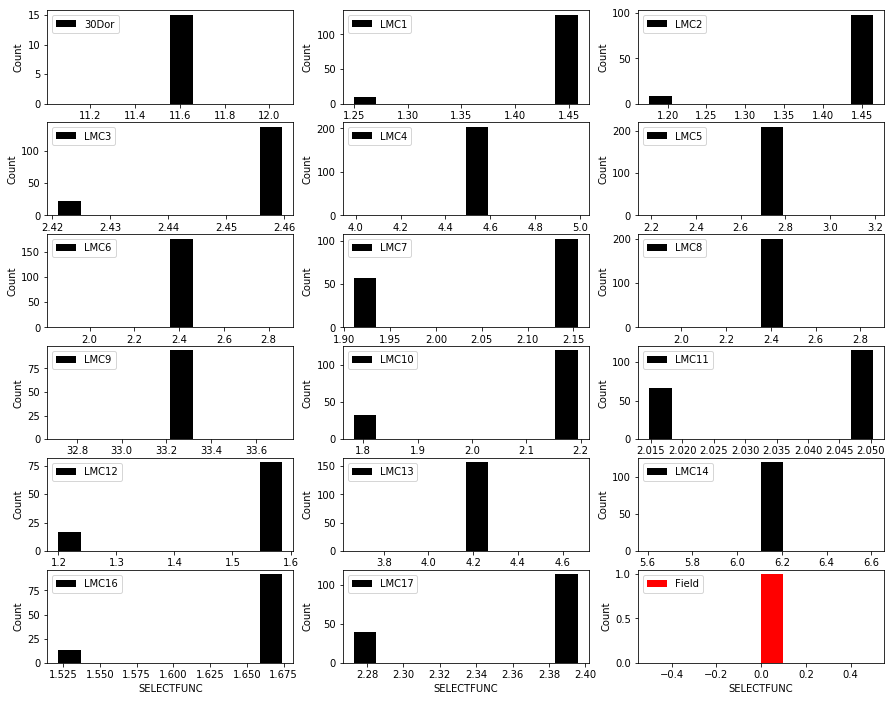

In [38]:
f, ax = plt.subplots(6,3, facecolor='w',figsize=(15,12))
ax[0,0].hist(clndr16['SELECTFUNC'][dor30],color='k',label='30Dor')
ax[0,0].set_xlabel('SELECTFUNC')
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('Count')

ax[0,1].hist(clndr16['SELECTFUNC'][lmc1],color='k',label='LMC1')
ax[0,1].set_xlabel('SELECTFUNC')
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('Count')

ax[0,2].hist(clndr16['SELECTFUNC'][lmc2],color='k',label='LMC2')
ax[0,2].set_xlabel('SELECTFUNC')
ax[0,2].legend(loc='upper left')
ax[0,2].set_ylabel('Count')

ax[1,0].hist(clndr16['SELECTFUNC'][lmc3],color='k',label='LMC3')
ax[1,0].set_xlabel('SELECTFUNC')
ax[1,0].legend(loc='upper left')
ax[1,0].set_ylabel('Count')

ax[1,1].hist(clndr16['SELECTFUNC'][lmc4],color='k',label='LMC4')
ax[1,1].set_xlabel('SELECTFUNC')
ax[1,1].legend(loc='upper left')
ax[1,1].set_ylabel('Count')

ax[1,2].hist(clndr16['SELECTFUNC'][lmc5],color='k',label='LMC5')
ax[1,2].set_xlabel('SELECTFUNC')
ax[1,2].legend(loc='upper left')
ax[1,2].set_ylabel('Count')

ax[2,0].hist(clndr16['SELECTFUNC'][lmc6],color='k',label='LMC6')
ax[2,0].set_xlabel('SELECTFUNC')
ax[2,0].legend(loc='upper left')
ax[2,0].set_ylabel('Count')

ax[2,1].hist(clndr16['SELECTFUNC'][lmc7],color='k',label='LMC7')
ax[2,1].set_xlabel('SELECTFUNC')
ax[2,1].legend(loc='upper left')
ax[2,1].set_ylabel('Count')

ax[2,2].hist(clndr16['SELECTFUNC'][lmc8],color='k',label='LMC8')
ax[2,2].set_xlabel('SELECTFUNC')
ax[2,2].legend(loc='upper left')
ax[2,2].set_ylabel('Count')

ax[3,0].hist(clndr16['SELECTFUNC'][lmc9],color='k',label='LMC9')
ax[3,0].set_xlabel('SELECTFUNC')
ax[3,0].legend(loc='upper left')
ax[3,0].set_ylabel('Count')

ax[3,1].hist(clndr16['SELECTFUNC'][lmc10],color='k',label='LMC10')
ax[3,1].set_xlabel('SELECTFUNC')
ax[3,1].legend(loc='upper left')
ax[3,1].set_ylabel('Count')

ax[3,2].hist(clndr16['SELECTFUNC'][lmc11],color='k',label='LMC11')
ax[3,2].set_xlabel('SELECTFUNC')
ax[3,2].legend(loc='upper left')
ax[3,2].set_ylabel('Count')

ax[4,0].hist(clndr16['SELECTFUNC'][lmc12],color='k',label='LMC12')
ax[4,0].set_xlabel('SELECTFUNC')
ax[4,0].legend(loc='upper left')
ax[4,0].set_ylabel('Count')

ax[4,1].hist(clndr16['SELECTFUNC'][lmc13],color='k',label='LMC13')
ax[4,1].set_xlabel('SELECTFUNC')
ax[4,1].legend(loc='upper left')
ax[4,1].set_ylabel('Count')

ax[4,2].hist(clndr16['SELECTFUNC'][lmc14],color='k',label='LMC14')
ax[4,2].set_xlabel('SELECTFUNC')
ax[4,2].legend(loc='upper left')
ax[4,2].set_ylabel('Count')

ax[5,0].hist(clndr16['SELECTFUNC'][lmc16],color='k',label='LMC16')
ax[5,0].set_xlabel('SELECTFUNC')
ax[5,0].legend(loc='upper left')
ax[5,0].set_ylabel('Count')

ax[5,1].hist(clndr16['SELECTFUNC'][lmc17],color='k',label='LMC17')
ax[5,1].set_xlabel('SELECTFUNC')
ax[5,1].legend(loc='upper left')
ax[5,1].set_ylabel('Count')

ax[5,2].hist(0,color='r',label='Field')
ax[5,2].set_xlabel('SELECTFUNC')
ax[5,2].legend(loc='upper left')
ax[5,2].set_ylabel('Count')

f.show()

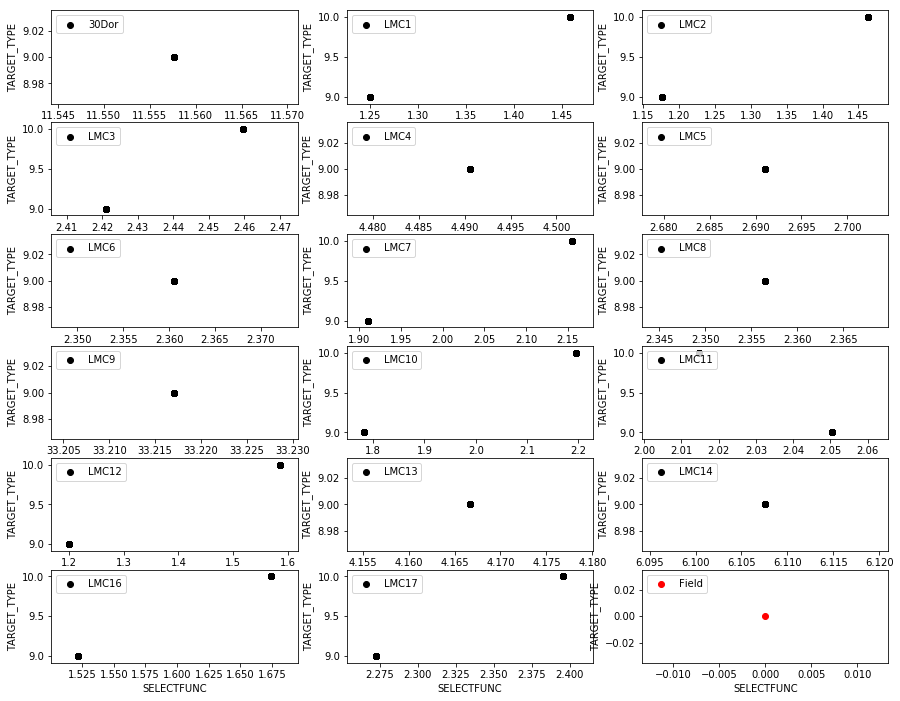

In [46]:
f, ax = plt.subplots(6,3, facecolor='w',figsize=(15,12))
ax[0,0].scatter(clndr16['SELECTFUNC'][dor30],clndr16['TARGET_TYPE'][dor30],color='k',label='30Dor')
ax[0,0].set_xlabel('SELECTFUNC')
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('TARGET_TYPE')

ax[0,1].scatter(clndr16['SELECTFUNC'][lmc1],clndr16['TARGET_TYPE'][lmc1],color='k',label='LMC1')
ax[0,1].set_xlabel('SELECTFUNC')
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('TARGET_TYPE')

ax[0,2].scatter(clndr16['SELECTFUNC'][lmc2],clndr16['TARGET_TYPE'][lmc2],color='k',label='LMC2')
ax[0,2].set_xlabel('SELECTFUNC')
ax[0,2].legend(loc='upper left')
ax[0,2].set_ylabel('TARGET_TYPE')

ax[1,0].scatter(clndr16['SELECTFUNC'][lmc3],clndr16['TARGET_TYPE'][lmc3],color='k',label='LMC3')
ax[1,0].set_xlabel('SELECTFUNC')
ax[1,0].legend(loc='upper left')
ax[1,0].set_ylabel('TARGET_TYPE')

ax[1,1].scatter(clndr16['SELECTFUNC'][lmc4],clndr16['TARGET_TYPE'][lmc4],color='k',label='LMC4')
ax[1,1].set_xlabel('SELECTFUNC')
ax[1,1].legend(loc='upper left')
ax[1,1].set_ylabel('TARGET_TYPE')

ax[1,2].scatter(clndr16['SELECTFUNC'][lmc5],clndr16['TARGET_TYPE'][lmc5],color='k',label='LMC5')
ax[1,2].set_xlabel('SELECTFUNC')
ax[1,2].legend(loc='upper left')
ax[1,2].set_ylabel('TARGET_TYPE')

ax[2,0].scatter(clndr16['SELECTFUNC'][lmc6],clndr16['TARGET_TYPE'][lmc6],color='k',label='LMC6')
ax[2,0].set_xlabel('SELECTFUNC')
ax[2,0].legend(loc='upper left')
ax[2,0].set_ylabel('TARGET_TYPE')

ax[2,1].scatter(clndr16['SELECTFUNC'][lmc7],clndr16['TARGET_TYPE'][lmc7],color='k',label='LMC7')
ax[2,1].set_xlabel('SELECTFUNC')
ax[2,1].legend(loc='upper left')
ax[2,1].set_ylabel('TARGET_TYPE')

ax[2,2].scatter(clndr16['SELECTFUNC'][lmc8],clndr16['TARGET_TYPE'][lmc8],color='k',label='LMC8')
ax[2,2].set_xlabel('SELECTFUNC')
ax[2,2].legend(loc='upper left')
ax[2,2].set_ylabel('TARGET_TYPE')

ax[3,0].scatter(clndr16['SELECTFUNC'][lmc9],clndr16['TARGET_TYPE'][lmc9],color='k',label='LMC9')
ax[3,0].set_xlabel('SELECTFUNC')
ax[3,0].legend(loc='upper left')
ax[3,0].set_ylabel('TARGET_TYPE')

ax[3,1].scatter(clndr16['SELECTFUNC'][lmc10],clndr16['TARGET_TYPE'][lmc10],color='k',label='LMC10')
ax[3,1].set_xlabel('SELECTFUNC')
ax[3,1].legend(loc='upper left')
ax[3,1].set_ylabel('TARGET_TYPE')

ax[3,2].scatter(clndr16['SELECTFUNC'][lmc11],clndr16['TARGET_TYPE'][lmc11],color='k',label='LMC11')
ax[3,2].set_xlabel('SELECTFUNC')
ax[3,2].legend(loc='upper left')
ax[3,2].set_ylabel('TARGET_TYPE')

ax[4,0].scatter(clndr16['SELECTFUNC'][lmc12],clndr16['TARGET_TYPE'][lmc12],color='k',label='LMC12')
ax[4,0].set_xlabel('SELECTFUNC')
ax[4,0].legend(loc='upper left')
ax[4,0].set_ylabel('TARGET_TYPE')

ax[4,1].scatter(clndr16['SELECTFUNC'][lmc13],clndr16['TARGET_TYPE'][lmc13],color='k',label='LMC13')
ax[4,1].set_xlabel('SELECTFUNC')
ax[4,1].legend(loc='upper left')
ax[4,1].set_ylabel('TARGET_TYPE')

ax[4,2].scatter(clndr16['SELECTFUNC'][lmc14],clndr16['TARGET_TYPE'][lmc14],color='k',label='LMC14')
ax[4,2].set_xlabel('SELECTFUNC')
ax[4,2].legend(loc='upper left')
ax[4,2].set_ylabel('TARGET_TYPE')

ax[5,0].scatter(clndr16['SELECTFUNC'][lmc16],clndr16['TARGET_TYPE'][lmc16],color='k',label='LMC16')
ax[5,0].set_xlabel('SELECTFUNC')
ax[5,0].legend(loc='upper left')
ax[5,0].set_ylabel('TARGET_TYPE')

ax[5,1].scatter(clndr16['SELECTFUNC'][lmc17],clndr16['TARGET_TYPE'][lmc17],color='k',label='LMC17')
ax[5,1].set_xlabel('SELECTFUNC')
ax[5,1].legend(loc='upper left')
ax[5,1].set_ylabel('TARGET_TYPE')

ax[5,2].scatter(0,0,color='r',label='Field')
ax[5,2].set_xlabel('SELECTFUNC')
ax[5,2].legend(loc='upper left')
ax[5,2].set_ylabel('TARGET_TYPE')

f.show()

In [51]:
print(set(np.copy(clndr16['TARGET_NAME'])))
print(set(np.copy(clndr16['TARGET_TYPE'])))
print(clndr16['TARGET_NAME'][0])
print(clndr16['TARGET_TYPE'][0])

{'BrtRGB', 'FntRGB'}
{9, 10}
BrtRGB
9
